In [1]:
import videoReplayFast

In [2]:
gen = videoReplayFast.threadedProvide()

In [3]:
q = next(gen)

In [4]:
import tensorflow as tf
import numpy as np

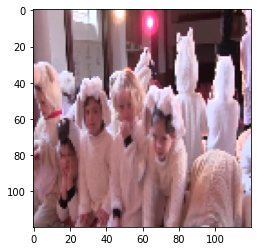

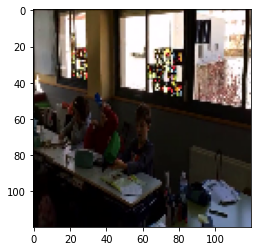

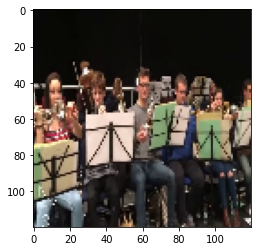

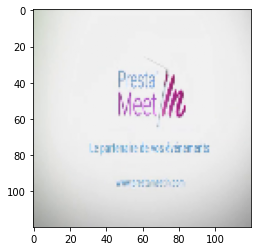

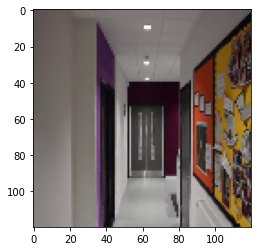

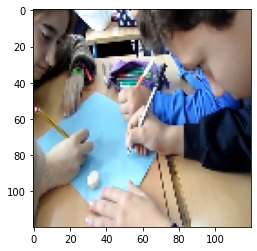

In [5]:
def training_generator():
    while True:
        inp = next(gen).numpy().astype(np.float32) / 255.
        yield (inp[:, :, :, [2, 1, 0]], inp[:, :, :, [6, 5, 4]]), inp[:, :, :, [6, 5, 4]]

import matplotlib.pyplot as plt
for _ in range(6):
    plt.imshow(next(training_generator())[0][0][0])
    plt.show()

In [6]:
import numpy as np

In [7]:
import tensorflow as tf

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

2021-09-06 16:21:59.400835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-06 16:22:03.353236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46729 MB memory:  -> device: 0, name: RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2021-09-06 16:22:03.365286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46729 MB memory:  -> device: 1, name: RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2021-09-06 16:22:03.374052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Running on multiple GPUs  ['/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3']
Number of accelerators:  4


In [8]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.001
LEARNING_RATE_EXP_DECAY = 1# = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

SCALE = 1
SIDE_LENGTH = 90





In [9]:
q = training_generator()


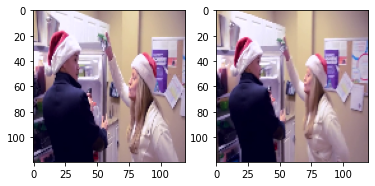

In [10]:
import matplotlib.pyplot as plt
a = next(q)
plt.subplot(1, 2, 1)
plt.imshow(a[0][0][60])
plt.subplot(1, 2, 2)
plt.imshow(a[0][1][60])

In [11]:
FEATURE_LENGTH = 128

def make_model():
    model = tf.keras.Sequential(
      [
        
        #tf.keras.layers.ZeroPadding2D(padding=(15, 15), input_shape=(SIDE_LENGTH, SIDE_LENGTH, 1)),
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=128, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=256, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
       
        tf.keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm
       
        tf.keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        #tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        #tf.keras.layers.Activation('relu'), # activation after batch norm
      ])
    
    input_A = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    input_B = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    features_A = model(input_A)
    features_B = model(input_B)

    features_A = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, FEATURE_LENGTH))(features_A)
    features_B = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, FEATURE_LENGTH))(features_B)

    cc = tf.keras.layers.Lambda(lambda var: tf.linalg.matmul(var[0], var[1], transpose_b=True), name="matmul")([features_A, features_B])

    cc_A = tf.keras.layers.Softmax(axis=-1)(cc)
    cc_B = tf.keras.layers.Softmax(axis=-2)(cc)

    loss = tf.keras.layers.Multiply()([cc_A, cc_B])

    loss = tf.keras.layers.Lambda(lambda var: tf.clip_by_value(var, 0, .3), name="clip")(loss)

    def fmapICON_clamp_loss(tensor, nonsense):
    
      return -tf.math.reduce_sum(nonsense) / BATCH_SIZE / SIDE_LENGTH / SIDE_LENGTH * strategy.num_replicas_in_sync

    outer_model = tf.keras.Model(inputs=(input_A, input_B), outputs=loss)

    outer_model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss=fmapICON_clamp_loss)
    return outer_model
    
with strategy.scope():
    model = make_model()
# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
EPOCHS = 60
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
  
history = model.fit(training_generator(),
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    callbacks=[lr_decay])

final_stats = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", final_stats[1])

Steps per epoch:  937


2021-09-06 16:22:09.411845: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1339"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        di

Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 9 all-reduces with algorithm = nccl, num_packs = 1


2021-09-06 16:22:20.833460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-06 16:22:22.854496: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-06 16:22:24.629826: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-09-06 16:22:25.978943: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-06 16:22:29.521473: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


599/937 [==================>...........] - ETA: 6:06 - loss: -0.2168

[matroska,webm @ 0x56546f081bc0] EBML header parsing failed


937/937 [==============================] - 1053s 1s/step - loss: -0.2242
Epoch 2/60

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1012s 1s/step - loss: -0.2431
Epoch 3/60

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
562/937 [================>.............] - ETA: 6:46 - loss: -0.2483

[matroska,webm @ 0x56546eacbd00] EBML header parsing failed


704/937 [=====================>........] - ETA: 4:12 - loss: -0.2493

[matroska,webm @ 0x56546ed61f00] EBML header parsing failed


711/937 [=====================>........] - ETA: 4:05 - loss: -0.2493

[matroska,webm @ 0x56546ed18f40] EBML header parsing failed


937/937 [==============================] - 1014s 1s/step - loss: -0.2509
Epoch 4/60

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1016s 1s/step - loss: -0.2685
Epoch 5/60

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1010s 1s/step - loss: -0.2746
Epoch 6/60

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
635/937 [===================>..........] - ETA: 5:27 - loss: -0.2799

[matroska,webm @ 0x56546f0f4900] EBML header parsing failed


937/937 [==============================] - 1019s 1s/step - loss: -0.2797
Epoch 7/60

Epoch 00007: LearningRateScheduler setting learning rate to 0.001.
894/937 [===========================>..] - ETA: 46s - loss: -0.2790

[matroska,webm @ 0x56546f4fd400] EBML header parsing failed


932/937 [============================>.] - ETA: 5s - loss: -0.2790

[matroska,webm @ 0x56546f991d00] EBML header parsing failed


937/937 [==============================] - 1011s 1s/step - loss: -0.2791
Epoch 8/60

Epoch 00008: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1017s 1s/step - loss: -0.2817
Epoch 9/60

Epoch 00009: LearningRateScheduler setting learning rate to 0.001.
320/937 [=========>....................] - ETA: 11:06 - loss: -0.2824

[matroska,webm @ 0x56546f0fa600] EBML header parsing failed


871/937 [==========================>...] - ETA: 1:11 - loss: -0.2818

[matroska,webm @ 0x56546ec22580] EBML header parsing failed


937/937 [==============================] - 1012s 1s/step - loss: -0.2819
Epoch 10/60

Epoch 00010: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1014s 1s/step - loss: -0.2867
Epoch 11/60

Epoch 00011: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1014s 1s/step - loss: -0.2883
Epoch 12/60

Epoch 00012: LearningRateScheduler setting learning rate to 0.001.
 17/937 [..............................] - ETA: 16:42 - loss: -0.2795

[matroska,webm @ 0x56546fac5240] EBML header parsing failed


558/937 [================>.............] - ETA: 6:49 - loss: -0.2846

[matroska,webm @ 0x56546f4ecc40] EBML header parsing failed


937/937 [==============================] - 1012s 1s/step - loss: -0.2864
Epoch 13/60

Epoch 00013: LearningRateScheduler setting learning rate to 0.001.
276/937 [=======>......................] - ETA: 11:58 - loss: -0.2920

[matroska,webm @ 0x56546efd0900] EBML header parsing failed


803/937 [========================>.....] - ETA: 2:24 - loss: -0.2923

[matroska,webm @ 0x56546f38c680] EBML header parsing failed


937/937 [==============================] - 1015s 1s/step - loss: -0.2916
Epoch 14/60

Epoch 00014: LearningRateScheduler setting learning rate to 0.001.
937/937 [==============================] - 1010s 1s/step - loss: -0.2904
Epoch 15/60

Epoch 00015: LearningRateScheduler setting learning rate to 0.001.
238/937 [======>.......................] - ETA: 12:42 - loss: -0.2952

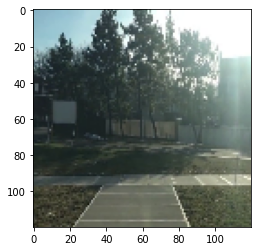

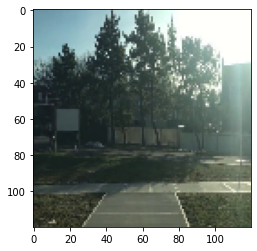

In [71]:
(A, B), Q = a
A = A[40:]
B = B[40:]
plt.imshow(A[0])
plt.show()
plt.imshow(B[0])
plt.show()

In [72]:
x = model((A[:3], B[:3]))

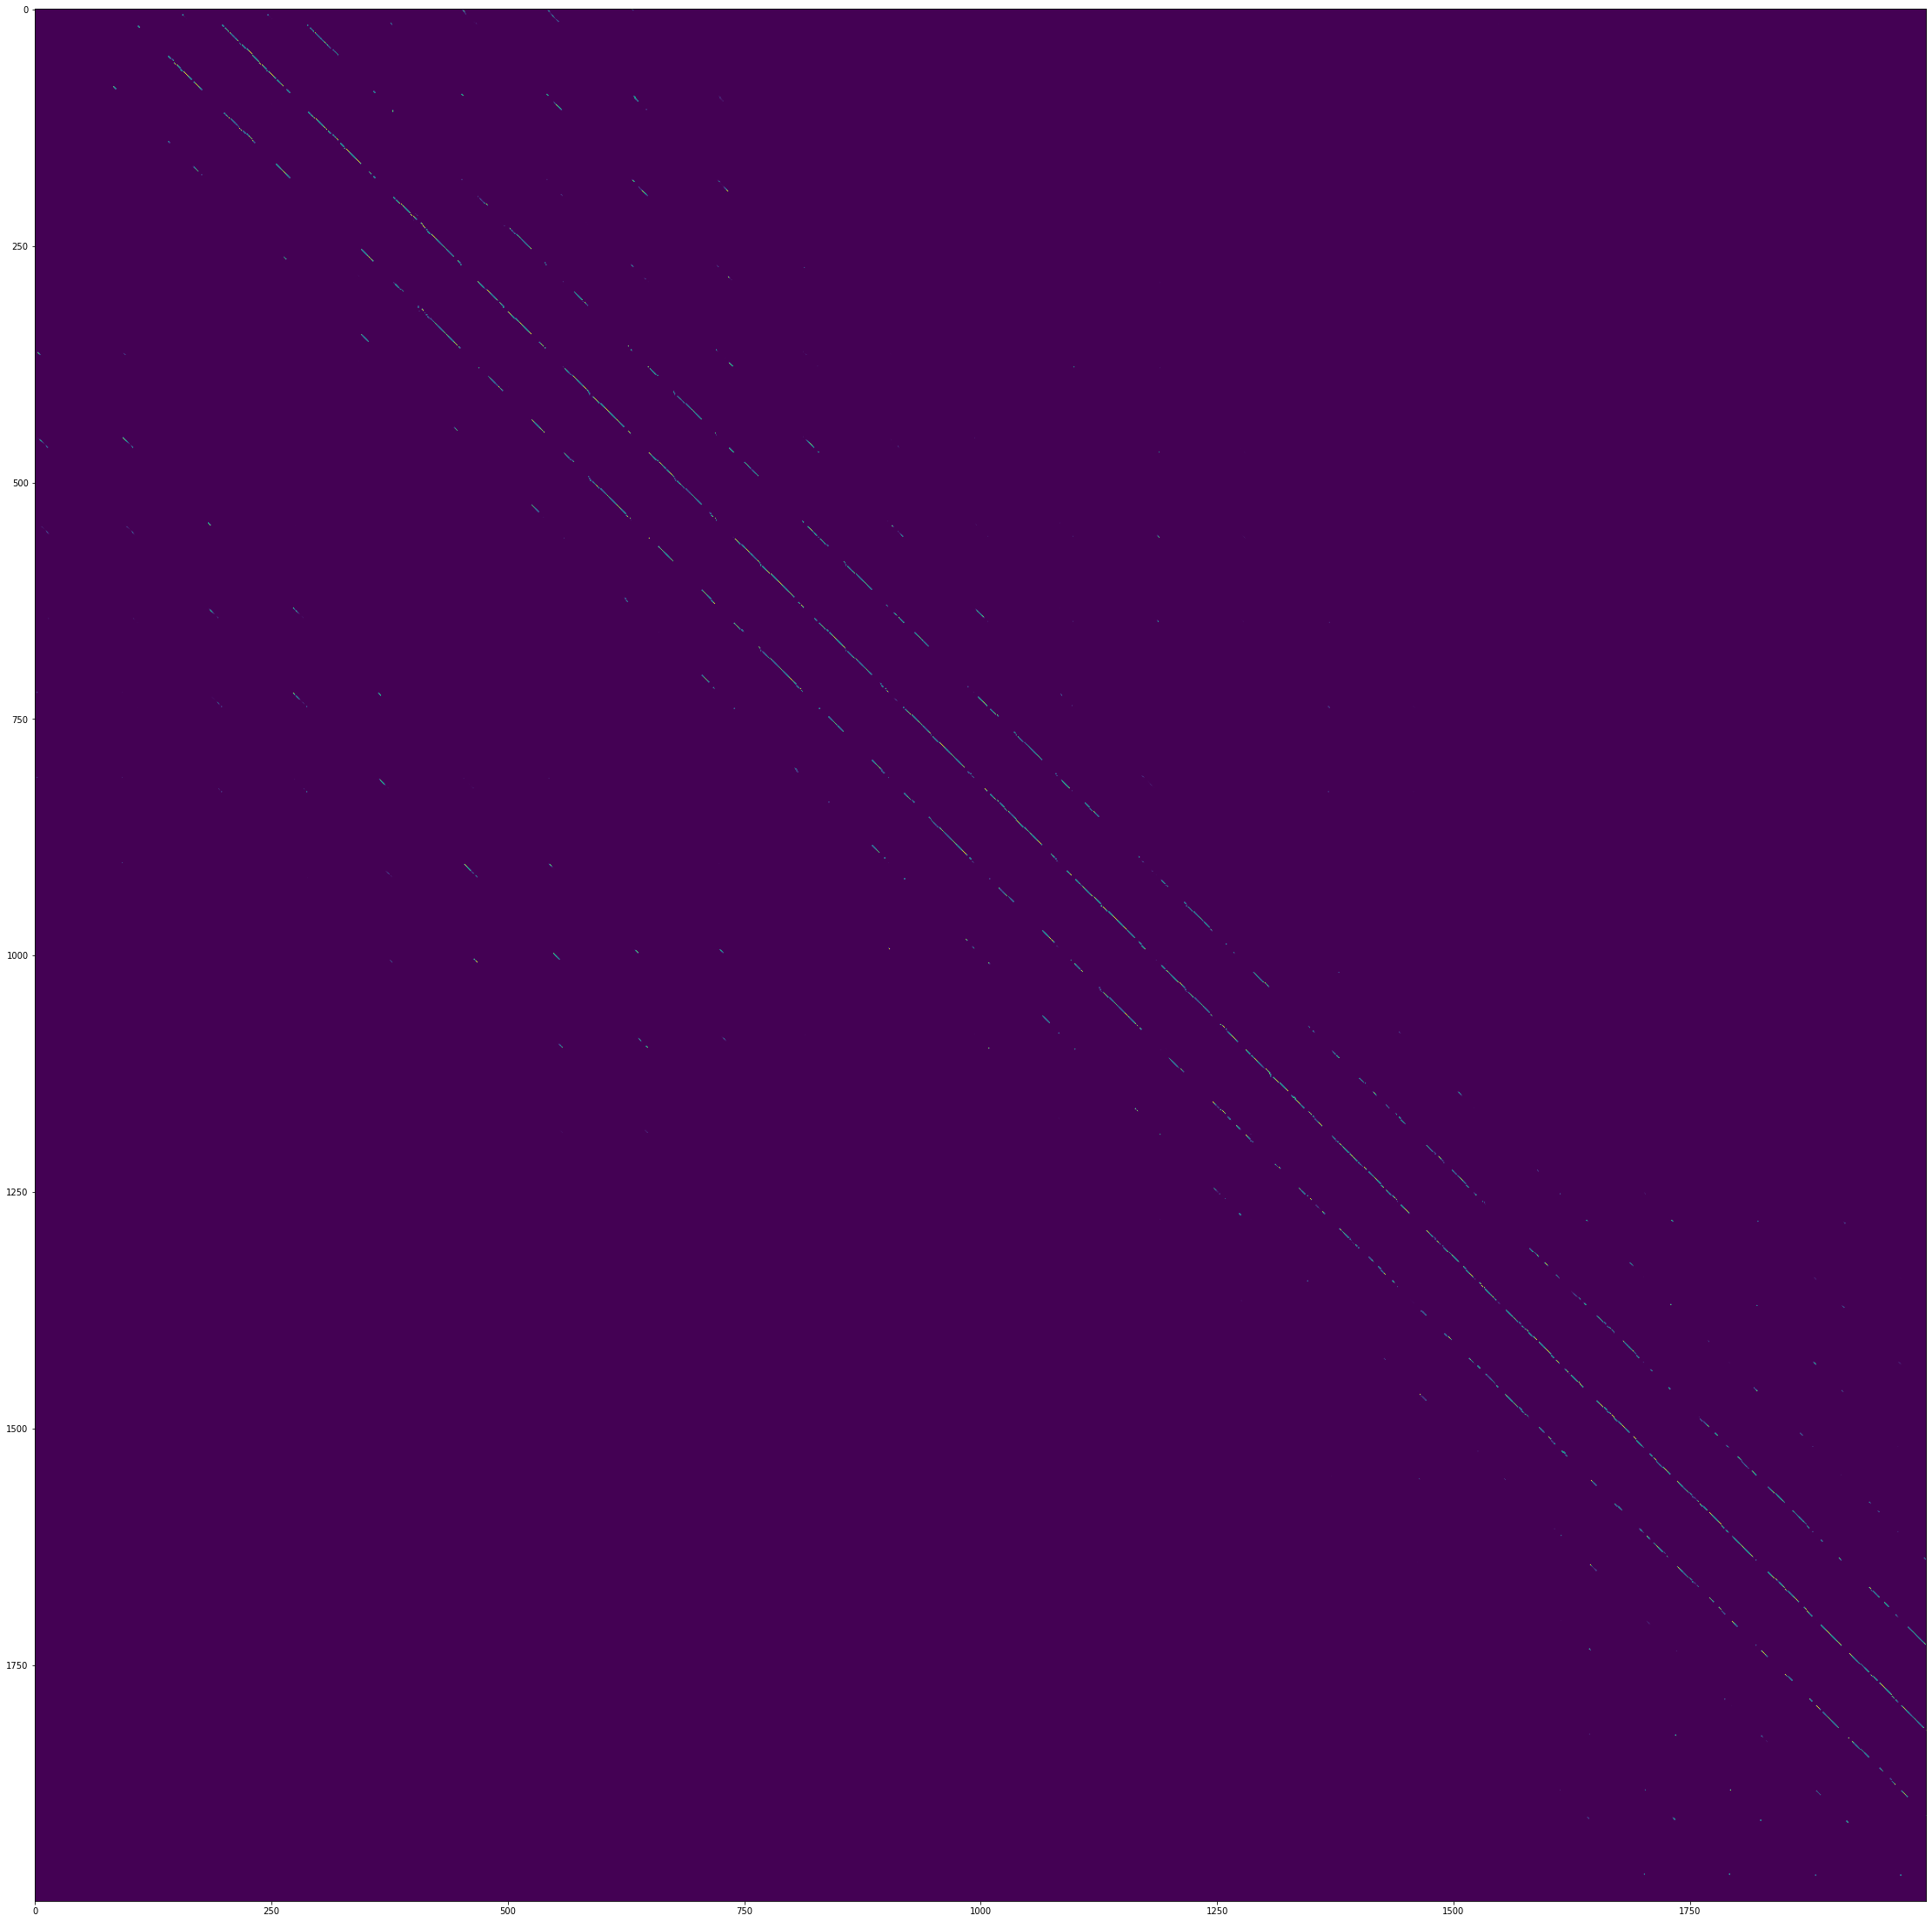

In [73]:
plt.figure(figsize=(40, 40))
plt.imshow(x[2, :2000, :2000])

In [74]:
inner_model = model.layers[2]

In [75]:
F_A = tf.reshape(inner_model(A)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
F_B = tf.reshape(inner_model(B)[:10], (10, SIDE_LENGTH ** 2, FEATURE_LENGTH))
cc = tf.linalg.matmul(F_A, F_B, transpose_b=True)
cc = tf.nn.softmax(cc, axis=-1)
cc = tf.reshape(cc, [10] + [SIDE_LENGTH] * 4)
cc = np.array(cc)

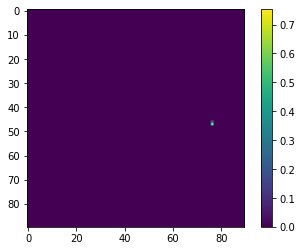

In [76]:
plt.imshow(cc[5, 45, 68])
plt.colorbar()

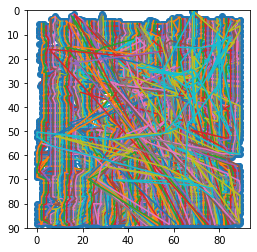

In [77]:
plt.figure(figsize=(4, 4))
import scipy.ndimage
grid = np.array(
  [
    [
        [
            scipy.ndimage.measurements.center_of_mass(cc[k, i, j].transpose())
            for i in range(SIDE_LENGTH)
        ]
        for j in range(SIDE_LENGTH)
    ]
   for k in range(10)]
)
#grid[:, :, 0] = scipy.ndimage.gaussian_filter(grid[:, :, 0], 1)
#grid[:, :, 1] = scipy.ndimage.gaussian_filter(grid[:, :, 1], 1)

#grid = grid[3:-3, 3:-3]

plt.plot(grid[0, :, :, 0], grid[0, :, :, 1])
plt.plot(grid[0, :, :, 0].transpose(), grid[0, :, :, 1].transpose())
plt.ylim(SIDE_LENGTH, 0)

plt.scatter(grid[0, :, :, 0], grid[0, :, :, 1])

plt.ylim(SIDE_LENGTH, 0)
plt.show()

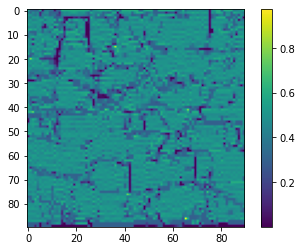

In [78]:
plt.imshow(tf.reshape(tf.reduce_sum(x, axis=-1)[1], (SIDE_LENGTH, SIDE_LENGTH)))
plt.colorbar()



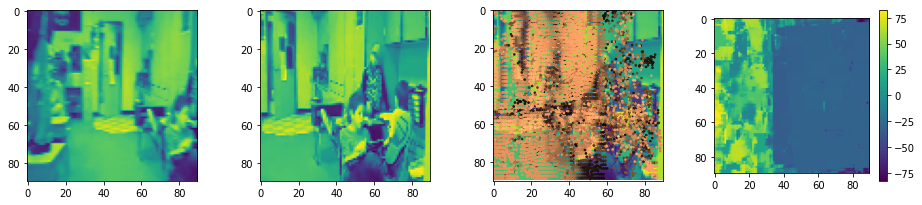

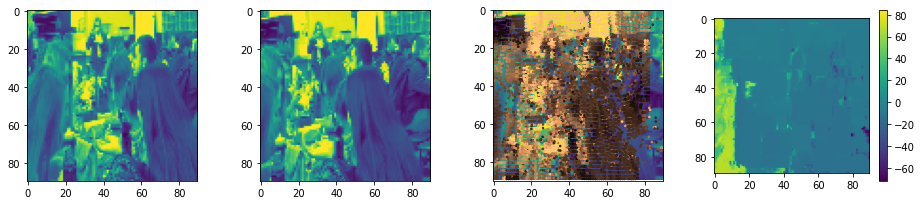

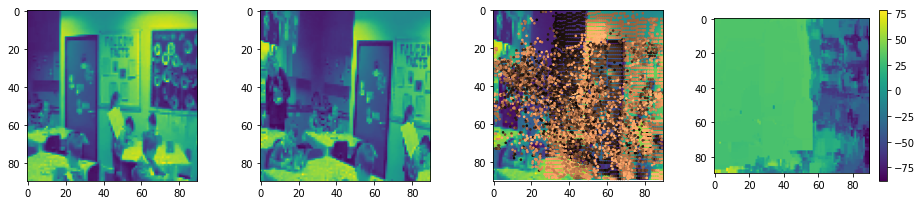

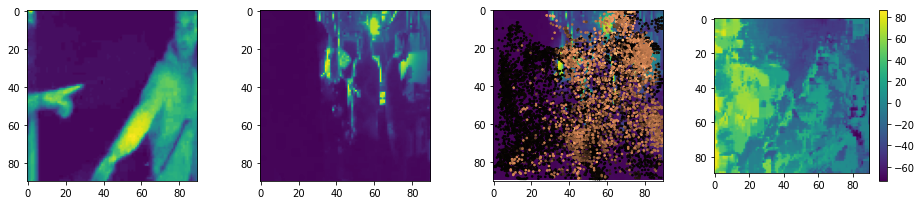

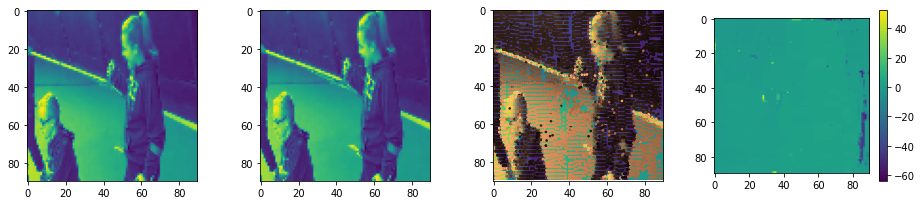

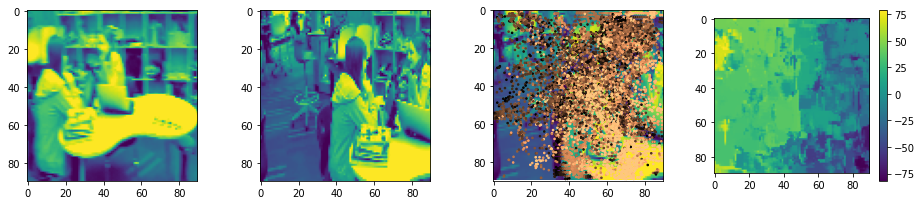

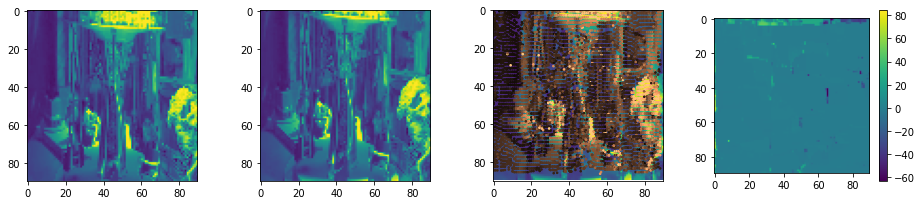

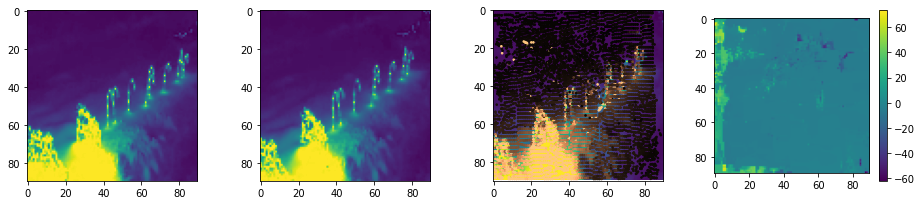

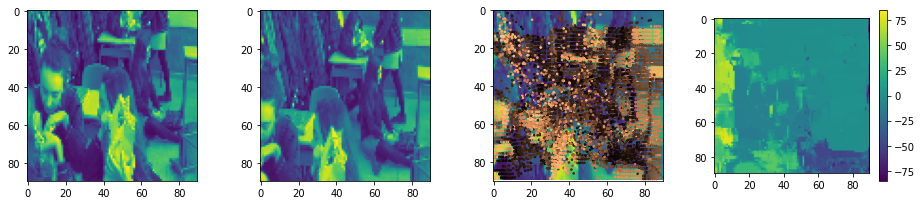

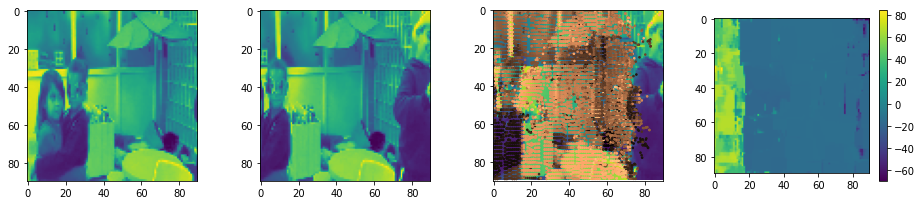

In [70]:
for k in range(10):
    plt.figure(figsize=(16, 37))
    plt.subplot(10, 4, 1)
    plt.imshow(A[k, 15:-15, 15:-15, 0])
    plt.subplot(10, 4, 2)
    plt.imshow(B[k, 15:-15, 15:-15, 0])
    plt.subplot(10, 4, 3)
    plt.ylim(SIDE_LENGTH, 0)
    plt.imshow(B[k, 15:-15, 15:-15, 0])
    plt.scatter(grid[k, :, :, 0], grid[k, :, :, 1], c=np.array(A)[k, 15:-15, 15:-15, 0].transpose(), cmap="copper", s=2.5)
    plt.subplot(10, 4, 4)
    g = grid[k].transpose(1, 0, 2)
    plt.imshow(g[:, :, 0] - np.expand_dims(np.arange(90), 0))
    plt.colorbar()

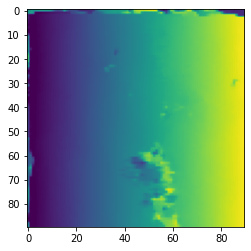

In [76]:
g = grid[0].transpose(1, 0, 2)
plt.imshow(g[:, :, 0])

In [32]:
f_a = np.array(F_A)#.reshape(90, 90, 128)
f_b = np.array(F_B)#.reshape(90, 90, 128)

In [33]:
f_a = f_a.reshape(-1, 128)
f_b = f_b.reshape(-1, 128)

In [34]:

from sklearn import decomposition
pca = decomposition.PCA(n_components=30)

x_a = pca.fit_transform(f_a)
x_b = pca.fit_transform(f_b)

In [35]:
x.shape

TensorShape([3, 8100, 8100])

In [36]:
x_a = x_a.reshape(10, 90, 90, 30)
x_b = x_b.reshape(10, 90, 90, 30)

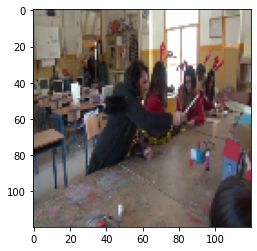

ValueError: cannot reshape array of size 2430000 into shape (10,90,90,128)

In [47]:
dd = 0
dd += 1
dd %= 10
plt.imshow(B[dd])
plt.show()
plt.imshow(f_a.reshape(10, 90, 90, 128)[dd, :, :, 0:3] / 2)
plt.show()
plt.imshow(f_b.reshape(10, 90, 90, 128)[dd, :, :, 0:3] / 8)

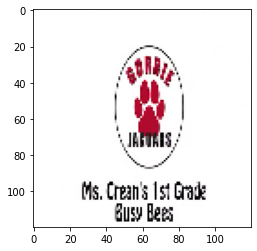

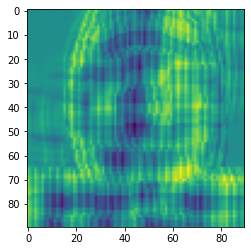

TypeError: Invalid shape (10, 90, 90, 128) for image data

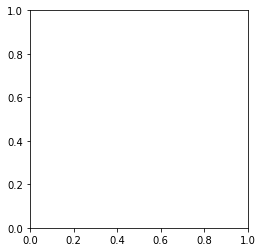

In [50]:
dd = 0
#dd += 1
#dd %= 10
plt.imshow(B[dd])
plt.show()
plt.imshow(np.sum(f_a.reshape(10, 90, 90, 128), axis=-1)[dd])
plt.show()
plt.imshow(f_b.reshape(10, 90, 90, 128))

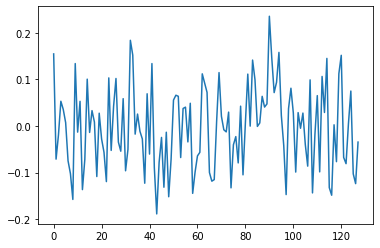

In [84]:
plt.plot(pca.components_[0])

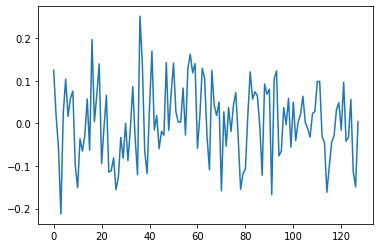

In [162]:
plt.plot(pca.components_[0])

In [44]:
w = model.get_weights()

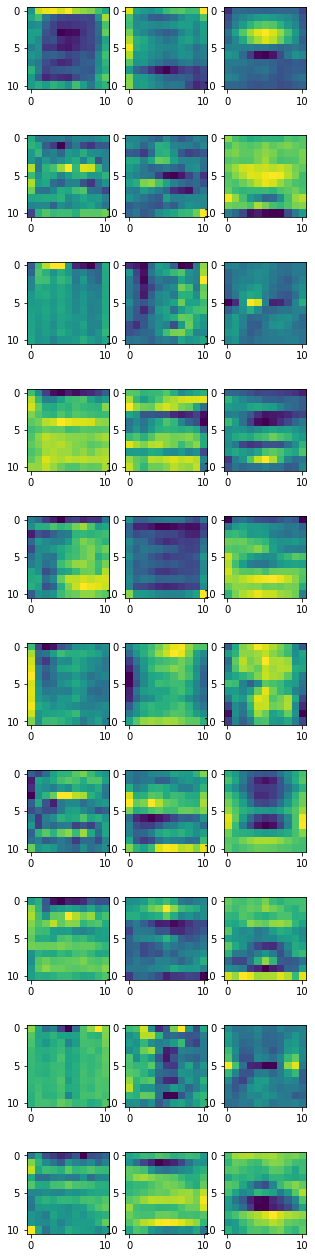

In [45]:
plt.figure(figsize=(5, 23))
for i in range(3):
    for j in range(10):
        plt.subplot(10, 3, 3 * j + i + 1)
        plt.imshow(w[8][:, :, i, j + 10])

In [79]:
model.save("longtrain_longgap")
model.save_weights("longtrain_longgap_w")

2021-09-07 17:22:14.744193: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: longtrain_longgap/assets


/playpen-raid1/tgreer/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
gen.gi_frame.f_locals

AttributeError: 'NoneType' object has no attribute 'f_locals'